# Todas las clases usadas:

In [1]:
%%writefile synt/const.py

CHUNK = 1024
SRATE = 48000
TIME = SRATE
TEST_TIME = SRATE*3

# notas = {
#     'C': 523.251,   # do
#     'D': 587.33,    # re
#     'E': 659.255,   # mi
#     'F': 698.456,   # fa
#     'G': 783.991,   # sol
#     'A': 880,       # la
#     'B': 987.767,   # si
#     'c': 1046.502,  # do
#     'd': 1174.659,  # re
#     'e': 1318.51,   # mi
#     'f': 1396.913,  # fa
#     'g': 1567.982,  # sol
#     'a': 1760,      # la
#     'b': 1975.533,  # si
# }

# mapeo de teclas del ordenador a notas en el piano
# utilizamos '.' para los sostenidos
teclas = "zsxdcvgbhnjmq2w3er5t6y7u"  # 2 de teclas filas 
notas =  "C.D.EF.G.A.Bc.d.ef.g.a.b"  # mapeadas a 2 octavas
# notas =  ""
#         octava baja||octava alta


# frecuencias de las notas asocidas a las teclas del teclado
# partimos del la=220Hz y generamos frecuencias de escala temperada
pitchs = [ 220*2.0**(i/12.0) for i in range(len(teclas))] 

# frecuencias asociadas a las notas midi de 0 a 127
# El LA central es la nota midi 70 y su frecuencia es 440
# contruimos hacia abajo y hacia arriba el resto de notas
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,59)]


notasAJ = [440, 495,      550,    586.67, 660,    733.33, 825]
notasAT = [440, 493.88,   554.36, 587.33, 659.26, 739.99, 830.61]
# notasAJ = [440, 466.16, 495, 523.25, 550, 586.67, 622.25, 660, 698.46, 733.33, 825] #las negras estan inventadas
# notasAT = [440, 466.16, 493.88, 523.25, 554.36, 587.33, 622.25, 659.26, 698.46, 739.99, 830.61]

#array que guarda los tonos hasta la siguiente nota con nombre (sin #)
aqglthlsncn = [2, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0] # no se usa

def getdiatonic(n, notas=notasAJ): #TODO: va raro
    pos = n % 7
    oct = n // 7
    return notas[pos] * (2 ** oct)

def diatonicAcorde(n, notas=notasAJ):
    "Devuelve el acorde diatonico relacionado con la frecuencia dada"
    _n = n
    return [getdiatonic(n, notas), getdiatonic( n + 2, notas), getdiatonic(n + 4, notas)]

Overwriting synt/const.py


In [2]:
%%writefile synt/effects.py

from synt.const import *
import numpy as np
import math

# TODO: en valores muy pequeños, intenta multiplicar arrays de tamaños distintos
class Delay:
    def __init__(self, input, time=1):
        self.osc = input
        _time = int(time * SRATE)
        self.time = _time
        self.frame = 0
        self.mem = np.zeros(_time)

    def next(self):
        signal = self.osc.next()
        chunk = len(signal)
        # se tiene que ir llenando desde atras :/
        if self.frame + chunk < self.time:  # si cabe
            _s = self.mem[self.frame:self.frame + chunk].copy()
            self.mem[self.frame:self.frame + chunk] = signal
            signal = _s
        else:
            rest = self.frame + chunk - self.time
            # cabe = selt.time - self.frame
            signal1 = self.mem[:rest].copy()
            signal2 = self.mem[self.frame:].copy()
            self.mem[:rest] = signal[chunk-rest:] 
            self.mem[self.frame:] =  signal[:chunk-rest]
            
            # self.mem[rest:chunk+rest] = signal
            _s = np.concatenate((signal2, signal1))
            # print(len(signal1))
            # print(len(signal1))
            # print(len(signal))
        self.frame = (self.frame + chunk) % self.time
        return _s

# TODO: en valores muy pequeños, intenta multiplicar arrays de tamaños distintos
class Echo:
    def __init__(self, osc, val=.5, time=1, restar=False):
        self.osc = osc
        self.val = val
        _time = int(time*SRATE)
        self.time = _time
        self.frame = 0
        self.mem = np.zeros(_time)
        self.restar = restar

    def next(self):
        signal = self.osc.next()
        chunk = len(signal)
        val_sig = 1
        val_echo = self.val
        # va un poco raro con restar = True
        if self.restar: 
            # val_sig = math.sqrt(1-self.val) # pongo esto porque no se si hacer que sea 1 o 1-val
            # val_echo = math.sqrt(self.val)
            
            val_sig = 1-self.val # pongo esto porque no se si hacer que sea 1 o 1-val
            val_echo = self.val
            
        if self.frame + chunk <= self.time:  # si cabe
            signal = signal * val_sig + (self.mem[self.frame:self.frame+chunk] * val_echo)
            self.mem[self.frame:self.frame+chunk] = signal
        else:
            rest = self.frame + chunk - self.time
            # rest = len(self.mem)-self.frame
            # self.mem = np.concatenate((np.zeros(rest - len(self.mem)-self.frame), self.mem))
            signal1 = signal[:self.time-self.frame] * val_sig + (self.mem[self.frame:self.time] * val_echo)
            signal2 = signal[self.time-self.frame:self.time-self.frame+rest] * val_sig + (self.mem[:rest] * val_echo)
            signal = np.concatenate((signal1, signal2))
            self.mem[self.frame:] = signal1
            self.mem[:rest] = signal2
        self.frame = (self.frame + chunk) % self.time
        return signal
    



Overwriting synt/effects.py


In [3]:
%%writefile synt/envolv.py

from synt.const import *
import numpy as np



'''Envolvente: Recibe una serie de puntos y crea una funcion que los recorre'''
class Env:
    def __init__(self, fun):
        self.fun = fun
        self.frame = 0
    
    def next(self, tiempo=None):
        
        if tiempo is None: # guarda su propio frame si no le dan uno
            _tiempo = np.arange(self.frame, self.frame+CHUNK)
            self.frame += CHUNK
        else:
            _tiempo = tiempo
            self.frame = tiempo[0]
        part = self.fun(_tiempo)
        if (len(part) < CHUNK):
            part = np.concatenate((part, np.zeros(CHUNK-len(part))))
        return part
    
class NoEnv(Env):
    def __init__(self):
        super().__init__(self.fun)
        
    def fun(self, tiempo=None):
        return np.full(CHUNK, 1)
    
class EnvPP(Env):
    def __init__(self, points):
        super().__init__(self.fun)
        env = np.zeros(0)
        # generamos la envolvente
        x0, y0 = points[0]
        
        _points = points[1:]
        if x0 != 0: # si el primero es 0, usamos el valor de y0, si no, empezamos en 0,0
            x0, y0 == 0, 0
            _points =np.concatenate(([(0,0)], points))
            
            
        for x, y in _points:
            x = round(x*SRATE) # traducir a segundos
            if x < 0: 
                x = 0
            env = np.concatenate((env, np.linspace(y0,y,x+1)[:-1])) # he quitado el [:-1] y no parece cambiar
            x0, y0, = x, y
        self.lastY = 0
        
        self.env = env
        
    def fun(self, tiempo=None):
        part = np.zeros(0)
        if (self.frame > len(self.env)):
            part = np.full(CHUNK, self.lastY)
            # print(self.lastY)
        else:
            part = self.env[self.frame:self.frame+CHUNK]
            rest = CHUNK - len(part)
            self.lastY = part[-1]
            if (len(part) < CHUNK):
                part = np.concatenate((part, np.full(rest, self.lastY)))
                
        self.lastY = part[-1]
        return part

# Esta envolvente tiene la duracion fija, no vale para el instrumento
class EnvADSR(EnvPP):
    '''
    atk, rel y sus van en segundos
    atk = segundos que tarda en crecer
    dec = segundos que tarda en alcanzar el sustain
    sus = valor que coge al decaer
    rel = segundos que tarda en decrecer
    dur = duracion total de la señal
    '''
    def __init__(self, atk, dec, sus, rel, dur):
        _atk = (atk, 1)
        _dec = (dec, sus)
        _sus = (dur - rel, sus)
        _rel = (rel, 0)
        super().__init__([_atk, _dec, _sus, _rel])

# Esta envolvente tiene tres estados, atk, rel y off
class EnvInstrumento:
    '''
    atk, rel y sus van en segundos
    atk = segundos que tarda en alcanzar el maximo
    dec = segundos que tarda en alcanzar el sustain
    sus = valor que coge al decaer
    rel = segundos que tarda en decrecer
    '''
    def __init__(self, atk, dec, sus, rel):
        _atk = (atk, 1)
        _dec = (dec, sus)
        # _sus = (dur - rel, sus)
        _rel = (rel, 0)
        self._rel = _rel
        self.sus = sus
        
        self.atk = EnvPP([_atk, _dec]) # empieza en 0, sube a 1 y luego decae a sus
        self.rel = EnvPP([(0,sus), _rel]) # empieza en sus y baja hasta 0 en rel segundos
        self.state = 'atk'
        
    
    def next(self, tiempo=None):
        ret = 0
        # print(self.state)
        if self.state == 'atk':
            ret = self.atk.next()
        elif self.state == 'rel':           
            ret = self.rel.next()
            if self.rel.frame > self._rel[0] * SRATE:
                # print(self.rel.frame)
                # print(self._rel[0])
                print('off')
                self.state = 'off'
        elif self.state == 'off':
            # return 0
            return np.zeros(CHUNK)
        return ret 
        
    '''TODO: podria hacer una funcion noteOn para que si se vuelve a activar una nota que ya estaba sonando
        en vez de acabarse de golpe y empezar de 0, que empieze self.rel.lastY para que no sea tan brusco el cambio 
    '''    
    def noteOff(self):
        self.state = 'rel'#TODO: INFO era que tenia puesto == 
        self.rel = EnvPP([(0, self.atk.lastY), self._rel]) # empieza en el ultimo y baja hasta 0 en rel segundos        
        
    def getLast(self):
        if self.state == 'atk':
            return self.atk.lastY
        if self.state == 'rel':
            return self.rel.lastY
        if self.state == 'off':
            return 0

Overwriting synt/envolv.py


In [4]:
%%writefile synt/function.py
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy.signal as sg
from synt.const import *

'''
    Funciones: Al usar .next(tiempo), devuelven un np.array con los 
    valores que representan la función en el tiempo especificado.
    Pensadas para emular la programacion declarativa
    
'''

class Function:
    def __init__(self):
        pass
    
    def __mul__(self, other):
        return Mult(self, other)
    
    def __truediv__(self, other):
        return Div(self, other)
    
    def __add__(self, other):
        return Add(self, other)
    
    def __sub__(self, other):
        return Sub(self, other)
        
    def next(self, tiempo):
        pass
    
class Add(Function): # f(x) = g(x) + h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def next(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g + _h
    
class Sub(Function): # f(x) = g(x) - h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def next(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g - _h  
    
class Mult(Function): # f(x) = g(x) * h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def next(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g * _h
    
class Div(Function): # f(x) = g(x) / h(x)
    def __init__(self, g, h):
        super().__init__()
        self.g = g
        self.h = h
        
    def next(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g / _h  
    
class Const(Function): # f(t) = valor
    def __init__(self, valor):
        super().__init__()
        self.valor = valor
        
    def __neg__(self):
        return Const(-self.valor)
    
    def next(self, tiempo):
        return np.full(len(tiempo), self.valor)
    
    def getValor(self):
        return self.valor
    
    def setValor(self, valor):
        self.valor = valor

    
class C(Const): # misma que const pero mas corta
    def __init__(self, valor):
        super().__init__(valor)
        
class X(Function): # f(t) = valor*t
    def __init__(self, valor=C(1)):
        super().__init__()
        self.valor = valor / C(SRATE)
        
    def next(self, tiempo):
        return tiempo * self.valor.next(tiempo)
    
class X1(Function): # f(t) = valor*t sin 0
    def __init__(self, valor=C(1)):
        super().__init__()
        self.valor = valor / C(SRATE)
        
    def next(self, tiempo):
        return tiempo * self.valor.next(tiempo) + 0.00001
    
class XP(Function):
    def __init__(self, valor, pow):
        super().__init__()
        self.valor = valor
        self.pow = pow
    
    def next(self, tiempo):
        return tiempo * self.valor.next(tiempo) ** self.pow.next(tiempo) + 0.00001
            
    
class FunOsc(Function): 
    '''Funcion osciladora (seno, triangulo, etc)'''
    def __init__(self, freq:Function, max=C(1), min=C(0), amp=None, phase=C(0)):
        super().__init__()
        self.freq = freq
        self.phase = phase
        if amp is None:
            self.max = max
            self.min = min
            self.amp = None
        else: 
            self.max = None
            self.min = None
            self.amp = amp
            
    def getFreq(self):
        return self.freq

    def setFreq(self, value):
        self.freq = value

    def getMax(self):
        return self.max

    def setMax(self, value):
        self.max = value

    def getMin(self):
        return self.min

    def setMin(self, value):
        self.min = value

    def getAmp(self):
        return self.amp

    def setAmp(self, value):
        self.amp = value

    def getPhase(self):
        return self.phase

    def setPhase(self, value):
        self.phase = value
        

class Sine(FunOsc): # f(t) = amp * sin(t * 2pi * freq + phase)
    def __init__(self, freq, max=C(1), min=C(0), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)
        
    def next(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = _amp * np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda + _offset
    
class Triangle(FunOsc): # f(t) = amp * arcsin(sin(t * 2pi * freq + phase))
    def __init__(self, freq, max=C(1), min=C(0), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)

    def next(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = (2 * _amp / np.pi) * np.arcsin(np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase))
        return onda + _offset
    
class Sawtooth(FunOsc): # f(t) = amp * arctan(tan(t * 2pi * freq + phase))
    def __init__(self, freq, max=C(1), min=C(0), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)

    def next(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        
        onda = (2 * _amp / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * _freq/SRATE) + _phase))
        return onda + _offset

class Square(FunOsc):
    def __init__(self, freq, max=C(1), min=C(0), amp=None, phase=C(0), duty=C(.5)):
        super().__init__(freq, max, min, amp, phase)
        self.duty = duty # no implementado

    def next(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = _amp * sg.square((2*np.pi * tiempo) * _freq / SRATE + _phase)
        return onda + _offset
    

class Tan(FunOsc): # f(t) = amp * tan(t * 2pi * freq + phase)
    def __init__(self, freq, max=C(1), min=C(0), amp=None, phase=C(0)):
        super().__init__(freq, max, min, amp, phase)

    def next(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)                
        
        onda = _amp * np.tan(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda + _offset
    



Overwriting synt/function.py


In [5]:
%%writefile synt/osc.py
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy.signal as sg
from synt.const import *
from synt.function import *

''' 
    osciladores: generan una onda nparray con unos parametros dados,
    las características particulares (bpm, etc) se declaran al
    inicializar el objeto correspondiente de la clase Osc o sus derivadas.
'''
# TODO: Son un poco redundantes con la clase function, lo mismo podría modificar el sintetizador para que use Function en todas partes
class Osc:    
    def __init__(self):
        pass
    
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        return np.zeros(len(tiempo)) # devuelve vacío

class Sine(Osc):
    def __init__(self):
        super().__init__()
        
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _freq = freq.next(tiempo) # frecuencia sobre el tiempo
        _amp = amp.next(tiempo) # amplitud sobre el tiempo
        _phase = phase.next(tiempo) 
        onda = _amp * np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda

class Square(Osc):
    def __init__(self, duty=Const(.5)):
        super().__init__()
        self.duty = duty

    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        # duty solo se puede usar en valor constante (por ahora)
        _duty = self.duty.next(tiempo)[0]
        _freq = freq.next(tiempo)  # frecuencia sobre el tiempo
        _amp = amp.next(tiempo)  # amplitud sobre el tiempo
        _phase = phase.next(tiempo)
        onda = _amp * sg.square(2*np.pi*tiempo*_freq/SRATE+_phase, _duty)
        return onda

class Triangle(Osc):
    def __init__(self):
        super().__init__()
        
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _freq = freq.next(tiempo)  # frecuencia sobre el tiempo
        _amp = amp.next(tiempo)  # amplitud sobre el tiempo
        _phase = phase.next(tiempo)
        onda = _amp * np.arcsin(np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase))
        return onda
    
class Sawtooth(Osc):
    def __init__(self):
        super().__init__()
        
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _freq = freq.next(tiempo)  # frecuencia sobre el tiempo
        _amp = amp.next(tiempo)  # amplitud sobre el tiempo
        _phase = phase.next(tiempo)
        onda = (2 *  _amp / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * _freq/SRATE) + _phase))
        return onda

class Kick(Osc):
    # no se que puede pasar si ponemos una funcion no constante en beat :0
    def __init__(self, bpm=C(130), beat=C(1), dur=C(1)):
        super().__init__()
        self.bpm = bpm
        self.dur = dur
        self.beat = beat

    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _bpm = self.bpm.next(tiempo)
        _beat = self.beat.next(tiempo)
        _negra = (SRATE*60/_bpm)/4
        _tiempo = (tiempo + _negra * _beat) % (_negra * 4) # desplazamiento del tiempo
        _freq = freq.next(_tiempo)  # frecuencia sobre el tiempo
        _amp = amp.next(_tiempo)  # amplitud sobre el tiempo
        _phase = phase.next(_tiempo)
        onda = _amp * np.sin((SRATE / self.dur) * (np.pi * _freq/SRATE)/(_tiempo+.1) + _phase)
        return onda

class Sinc(Osc):
    def __init__(self):
        super().__init__()
        
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _freq = freq.next(tiempo) # frecuencia sobre el tiempo
        _amp = amp.next(tiempo) # amplitud sobre el tiempo
        _phase = phase.next(tiempo) 
        onda = np.sin(tiempo * 2 * np.pi * _freq/SRATE + _phase) / (tiempo * 2 * np.pi * _freq/SRATE)
        return onda * _amp


class ModSawtooth(Osc):
    def __init__(self, other:Function):
        super().__init__()
        self.other = other
        
    def next(self, freq, tiempo, amp=Const(1), phase=Const(0)):
        _freq = freq.next(tiempo)  # frecuencia sobre el tiempo
        _amp = amp.next(tiempo)  # amplitud sobre el tiempo
        _phase = phase.next(tiempo)
        _other = self.other.next(tiempo)
        onda = (2 *  _amp / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * _freq/SRATE) + _phase) + _other)
        return onda

Overwriting synt/osc.py


In [6]:
%%writefile synt/synt.py
import numpy as np
from synt.const import *
from synt.function import *
from synt.envolv import *

import synt.osc as osc

class Synt:
    def __init__(self, freq, onda, amp=Const(1), phase=Const(0), env=NoEnv()):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.onda = onda
        self.frame = 0
        self.env = env
        
    def setAmp(self, amp):
        self.amp = amp
        
    def setOsc(self, onda):
        self.onda = onda
        
    def setPhase(self, phase):
        self.phase = phase
        
    def getPhase(self):
        return self.phase
    
    def getEnv(self):
        return self.env
    
    # tambien se puede usar como un oscilador
    def next(self, tiempo=None):
        if tiempo is None:
            tiempo = np.arange(self.frame, CHUNK + self.frame, 1) # array con el tiempo
        self.frame += CHUNK
        # print (self.onda)
        return self.onda.next(self.freq, tiempo, self.amp, self.phase) * self.env.next(tiempo)


class PolySynt:
    def __init__(self, freqs, ondas, amp=C(1), amps=[Const(1)], phases=[Const(0)], env=NoEnv()):
        n = len(freqs)
        while len(ondas) < n:
            ondas.append(ondas[0])
        while len(amps) < n:
            amps.append(amps[0])
        while len(phases) < n:
            phases.append(phases[0])
        self.n = n
        self.freqs = freqs
        self.amps = amps
        self.phases = phases  
        self.ondas = ondas
        self.frame = 0
        self.env = env
        self.amp = amp
        
    # def setAmps(self, amps):
        # self.amps = amps
        
    # def setOscs(self, ondas):
        # self.ondas = ondas
        
    # def setPhases(self, phases):
        # self.phases = phases
        
    # def getPhases(self):
        # return self.phases
        
    def next(self, tiempo=None):
        if tiempo is None:
            tiempo = np.arange(self.frame, CHUNK + self.frame, 1)
        self.frame += CHUNK
                
        res = np.zeros(CHUNK)
        _env = self.env.next(tiempo)
        for i in range(self.n):
            res = res + self.ondas[i].next(self.freqs[i], tiempo, self.amps[i] / C(len(self.freqs)), self.phases[i]) * _env
            
        
            
        return res * self.amp.next(tiempo) 
    
    def getEnv(self):
        return self.env
        
class HarmSynt(PolySynt):
    def __init__(self, nota, ondas, amp=C(1), amps=[Const(1)], phases=[Const(0)], env=NoEnv(), afinacion=notasAJ):
        
        _freqs = diatonicAcorde(nota, afinacion)
        freqs = []
        for f in _freqs:
            freqs.append(C(f))
        print(_freqs)
          
        super().__init__(freqs, ondas, amp, amps, phases, env)


Overwriting synt/synt.py


# Ejercicios:

In [7]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
import time


from synt.const import *
from synt.synt import *
import synt.osc as osc
from synt.function import *
from synt.envolv import *
from synt.effects import *
import os

In [8]:
'''REPRODUCTOR'''
input = None

def callback(outdata, frames, time, status):
    global input
    # print('entro')
    if input is not None:
        bloque = input.next()
        # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
        outdata[:] = bloque.reshape(-1, 1)
    else:
        # si no hay datos, reproducimos silencio
        outdata[:] = np.zeros((CHUNK, 1))


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [9]:
'''MOSTAR ONDAS COPIANDOLAS PARA QUE NO SE ALTERE EL FRAME'''
from copy import copy
def showOsc(osc, time, chunks=False):
    _osc = copy(osc)
    signal = np.zeros(0)
    _chunks = int(time*(SRATE+CHUNK)/CHUNK)
    if chunks:
        _chunks = time
    for i in range(_chunks):
        signal = np.concatenate((signal, _osc.next()))
    plt.plot(signal)

In [10]:
raise Exception("Para de ejecutar!!") #(comentar para ejecutar todo de una)

Exception: Para de ejecutar!!

## 1 y 2

In [ ]:
# Creación de los osciladores

fm = C(1000) # frecuencia de la onda FM
b_freq = C(3) # frecuencia del seno de beta
b_amp = C(.3) # amplitud del seno de beta

beta = Sine(b_freq, amp=b_amp) # amplitud de la onda FM
mod = Sine(fm, amp=beta) # onda que modula la frecuencia (FM)

sFreq = C(20) # frecuencia de la onda 
oscilador = osc.Sine()
synt = Synt(sFreq, oscilador, phase=mod)
input = synt


# Función para actualizar los osciladores según la selección en la interfaz
def update_oscillators():
    wave_synt = synt_wave_type.get()
    wave_modulator = modulator_wave_type.get()
    
    modulator = None
    if wave_modulator == 'sine':
        modulator = Sine(fm, amp=beta)
    elif wave_modulator == 'square':
        modulator = Square(fm, amp=osc.Sine())
    if wave_synt == 'sine':
        sOsc = osc.Sine()
    elif wave_synt == 'square':
        sOsc = osc.Square()
    elif wave_synt == 'sawtooth':
        sOsc =  osc.Sawtooth()
    elif wave_synt == 'triangle':
        sOsc = osc.Triangle()
        
    synt.setOsc(sOsc)
    
def update_beta_freq(val):
    newFreq = C(float(val))
    old_amp = synt.getPhase().getAmp().getAmp()

    newBeta = Sine(newFreq, amp=old_amp)
    newPhase = synt.getPhase()
    newPhase.setFreq(newBeta)
    synt.setPhase(newPhase)
    
def update_beta_amp(val):
    newAmp = C(float(val))
    old_freq = synt.getPhase().getAmp().getFreq()
    
    newBeta = Sine(old_freq, amp=newAmp)
    newPhase = synt.getPhase()
    newPhase.setAmp(newBeta)
    synt.setPhase(newPhase)
    
    

# Interfaz gráfica
root = Tk()
root.title("Síntesis FM con Selección de Onda")

Label(root, text="Forma de la onda del synt").pack()
synt_wave_type = StringVar(value='sine')
synt_menu = ttk.Combobox(root, textvariable=synt_wave_type, values=['sine', 'square', 'triangle', 'sawtooth'])
synt_menu.pack()

Label(root, text="Forma de la onda moduladora (fm)").pack()
modulator_wave_type = StringVar(value='sine')
modulator_menu = ttk.Combobox(root, textvariable=modulator_wave_type, values=['sine', 'square', 'triangle', 'sawtooth'])
modulator_menu.pack()

btn_apply = Button(root, text="Aplicar", command=update_oscillators)
btn_apply.pack()

lbl_status = Label(root, text="Carrier: sine, Modulator: sine")
lbl_status.pack()

# Label(root, text="Presiona teclas (a, s, d, f, g, h, j) para tocar notas").pack()
# root.bind("<KeyPress>", play_sound)


# root.title("Alteración de parametros de la onda moduladora")

Scale(root, from_=0., to=1000., resolution=0.1, orient=HORIZONTAL, label="Frecuencia de beta", command=update_beta_freq, length=400).pack()

Scale(root, from_=0., to=1., resolution=0.01, orient=HORIZONTAL, label="Amplitud de beta", command=update_beta_amp, length=400).pack()

# btn_apply = Button(root, text="Aplicar", command=update_oscillators)
# btn_apply.pack()


root.mainloop()

In [ ]:
input = None

## 3.
Suena mejor la afinacion ajustada, la temperada suena más vibrante (sucia) y se puede ver hasta en la forma de las ondas. Esto se puede deber a que la afinacion justa se basa en intervalos de frecuencia más armónicos mientras que la temperada busca que los saltos entre tonos sean todos proporcionales. 

In [ ]:
t = 1
[]
for i in range (-8, 9):
    print(str(i) + " Ajustada:")
    synt1 = HarmSynt(i, [osc.Triangle()], afinacion=notasAJ)
    
    # plt.show()
    input = synt1
    time.sleep(t)
    # input = None
    print(str(i) + " Atemperada:")
    synt2 = HarmSynt(i, [osc.Triangle()], afinacion=notasAT)

    # plt.show()
    input = synt2
    time.sleep(t)
    input = None


input = None


-8 Ajustada:
[206.25, 247.5, 293.335]
-8 Atemperada:
[207.6525, 246.94, 293.665]
-7 Ajustada:
[220.0, 275.0, 330.0]
-7 Atemperada:
[220.0, 277.18, 329.63]
-6 Ajustada:
[247.5, 293.335, 366.665]
-6 Atemperada:
[246.94, 293.665, 369.995]
-5 Ajustada:
[275.0, 330.0, 412.5]
-5 Atemperada:
[277.18, 329.63, 415.305]
-4 Ajustada:
[293.335, 366.665, 440]
-4 Atemperada:
[293.665, 369.995, 440]
-3 Ajustada:
[330.0, 412.5, 495]
-3 Atemperada:
[329.63, 415.305, 493.88]
-2 Ajustada:
[366.665, 440, 550]
-2 Atemperada:
[369.995, 440, 554.36]
-1 Ajustada:
[412.5, 495, 586.67]
-1 Atemperada:
[415.305, 493.88, 587.33]
0 Ajustada:
[440, 550, 660]
0 Atemperada:
[440, 554.36, 659.26]
1 Ajustada:
[495, 586.67, 733.33]
1 Atemperada:
[493.88, 587.33, 739.99]
2 Ajustada:
[550, 660, 825]
2 Atemperada:
[554.36, 659.26, 830.61]
3 Ajustada:
[586.67, 733.33, 880]
3 Atemperada:
[587.33, 739.99, 880]
4 Ajustada:
[660, 825, 990]
4 Atemperada:
[659.26, 830.61, 987.76]
5 Ajustada:
[733.33, 880, 1100]
5 Atemperada:
[739.

[586.67, 733.33, 880]
[587.33, 739.99, 880]


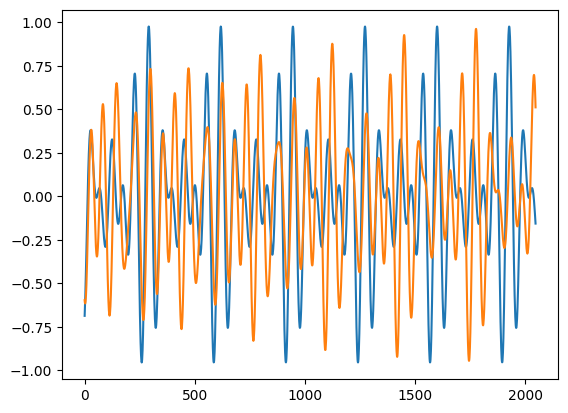

In [ ]:
synt1 = HarmSynt(3, [osc.Sine()], afinacion=notasAJ)
input = synt1
time.sleep(5)
synt2 = HarmSynt(3, [osc.Sine()], afinacion=notasAT) 
input = synt2
time.sleep(5)
showOsc(synt1, 2, True)
showOsc(synt2, 2, True)
input = None
# en naranja ajustada se puede ver como sus ondas son más picudas debido a que las relaciones 


In [ ]:
# Synt(C(60), osc.ModSawtooth(C(-.5)/X1()) ,env=EnvADSR(0.01, .1, .7, .3, .5), amp=C(1))
teclas = 'nmzxcvbyuqwert' # sin semitonos

class InstrumentoHarm:
    def __init__(self, tk:Tk, synt):
        # Creación de los osciladores

        self.synt = synt
        # canales indexados por la nota de lanzamiento -> solo una nota del mismo valor
        self.channels = dict()        
        self.tails = dict()
        self.afinacion = notasAJ
        
        self.octava = 4
        
        # interfaz
        frame = LabelFrame(tk, text="Sintetizador FM armónico", bg="#808090")
        frame.pack(side=LEFT)
        
        slider_octava =Scale(frame, from_=-1, to=10, resolution=1, orient=HORIZONTAL, label="Escala", command=self.change_octava, length=400)
        slider_octava.set(self.octava)
        slider_octava.pack()

        
        # una ventana de texto interactiva para poder lanzar notas con el teclado del ordenador
        text = Text(frame,height=4,width=40)
        self.afinacion_box = StringVar(value='Ajustada')
        afinador_menu = ttk.Combobox(frame, textvariable=self.afinacion_box, values=['Ajustada', 'Atemperada'])
        afinador_menu.pack()
        text.pack(side=BOTTOM)
        text.bind('<KeyPress>', self.down)
        text.bind('<KeyRelease>', self.up)

    # identificar y mandar reproducir la nota
    def down(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = teclas.index(c)
            print(f'noteOn {midiNote}')
            self.noteOn(midiNote)

    def up(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = teclas.index(c) # buscamos indice y hacemos el noteOff
            print(f'noteOff {midiNote}')
            self.noteOff(midiNote)
    
    def noteOn(self,midiNote):
        # si está el dict de canales apagamos nota actual con envolvente de fadeout
        # y guardamos en tails. El next devolverá este tail y luego comenzará la nota
        if midiNote in self.channels:                   
            lastAmp = self.channels[midiNote].getEnv().getLast() # ultimo valor de la envolvente: inicio del fadeOut
            # signal = self.channels[midiNote].next()     # señal          
            # self.tails[midiNote] = signal           # diccionario de tails (notas apagadas) 

        # generamos un nuevo synth en un canal indexado con notaMidi
        # con los parámetros actuales del synth
        if self.afinacion_box.get() == 'Ajustada' and self.afinacion != notasAJ:
            self.afinacion = notasAJ
            print('AJ')
        elif (self.afinacion_box.get() == 'Atemperada' and self.afinacion != notasAT):
            print('AT')
            self.afinacion = notasAT
        
        self.channels[midiNote] = HarmSynt(midiNote + (7 * self.octava), [osc.Sine()] ,env=EnvInstrumento(.2, .1, .7, 1), amps=[C(1), C(1), C(1)], amp=C(1), afinacion=self.afinacion)
        # self.channels[midiNote] = self.synt(midiNote, ondas = [osc.Sine()], env=EnvInstrumento(.01, .1, .7, .3)) #megasimple
        
        
    def noteOff(self, midiNote):
        if midiNote in self.channels: # está el dict, release
            self.channels[midiNote].getEnv().noteOff()
            
    def change_octava(self, val):
        self.octava = int(val) - 5

    # siguiente chunck del generador: sumamos señal de canales y hacemos limpia de silenciados
    def next(self):
        out = np.zeros(CHUNK)          
        for c in list(self.channels):            # convertimos las keys a lista para mantener la lista de claves original
            # print(self.channels[c].getEnv().state)
            if self.channels[c].getEnv().state == 'off':  # si no, modificamos diccionario en el bucle de recorrido de claves -> error 
                del self.channels[c]
            else: # si la nota está el diccionario de tails devolvemos el fadeout generado en noteOn y elminamos tail
                if c in self.tails:                  
                    out += self.tails[c]
                    del self.tails[c]
                else:
                    out += self.channels[c].next()
        # if out is list:       
            # out = out / np.max(out)
        if len(self.channels) > 0:
            # print(len(self.channels))
            out = out /len(self.channels)
        return out

[990, 1173.34, 1466.66]


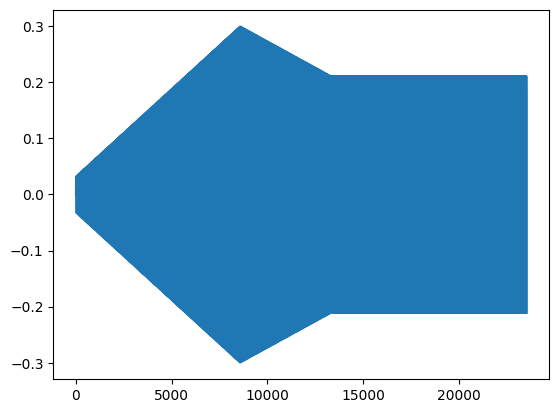

In [ ]:
root = Tk()
os.system('xset r off')
synt = HarmSynt
inst = InstrumentoHarm(root, synt)
inst.noteOn(-20)
showOsc(inst, 0.5)
# input = inst

# root.mainloop()
input = None

In [ ]:
# uso del instrumento

root = Tk()
os.system('xset r off')
synt = HarmSynt
inst = InstrumentoHarm(root, synt)
input = inst
root.mainloop()
input = None

noteOn 2
[275.0, 330.0, 412.5]
noteOff 2
noteOn 5
[366.665, 440, 550]
off
noteOff 5
noteOn 5
[366.665, 440, 550]
noteOff 5
noteOn 4
[330.0, 412.5, 495]
noteOff 4
off
noteOn 4
[330.0, 412.5, 495]
noteOff 4
noteOn 0
[220.0, 275.0, 330.0]
noteOff 0
noteOn 3
[293.335, 366.665, 440]
noteOff 3
noteOn 1
[247.5, 293.335, 366.665]
noteOff 1
off
off
noteOn 1
[247.5, 293.335, 366.665]
off
noteOff 1
noteOn 1
[247.5, 293.335, 366.665]
noteOff 1
noteOn 2
[275.0, 330.0, 412.5]
off
noteOff 2
noteOn 0
[220.0, 275.0, 330.0]
noteOff 0
noteOn 5
[366.665, 440, 550]
off
noteOff 5
off
noteOn 0
[220.0, 275.0, 330.0]
noteOff 0
off
noteOn 6
[412.5, 495, 586.67]
noteOff 6
off
noteOn 3
[293.335, 366.665, 440]
noteOn 2
[275.0, 330.0, 412.5]
noteOff 3
noteOff 2
off
noteOn 6
[412.5, 495, 586.67]
noteOff 6
off
noteOn 6
[412.5, 495, 586.67]
off
noteOff 6
noteOn 3
[293.335, 366.665, 440]
noteOff 3
noteOn 6
[412.5, 495, 586.67]
noteOff 6
noteOn 3
[293.335, 366.665, 440]
noteOff 3
noteOn 6
[412.5, 495, 586.67]
noteOff 6


Experimentos:

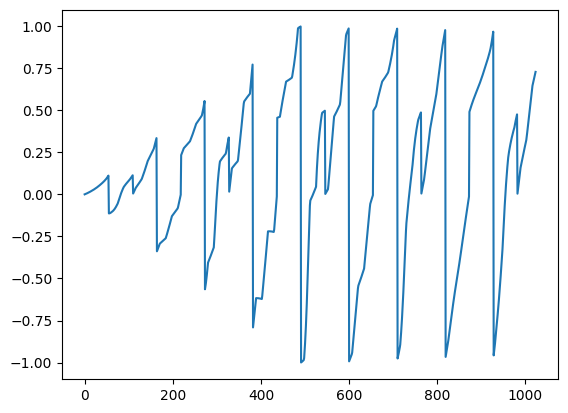

In [ ]:
synt = Synt(C(440), osc.ModSawtooth(Square(C(220))), phase=Triangle(C(1760), amp=Sawtooth(C(55), amp=C(.2))) ,env=EnvADSR(0.01, .1, .7, .3, .5), amp=C(1))
ec = Echo(copy(synt), .05, .1, restar=True)
showOsc(synt, 1, True)
input = ec

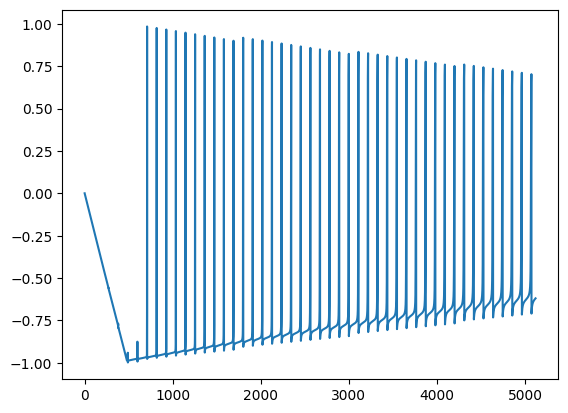

In [38]:
synt = Synt(C(440), osc.ModSawtooth(C(-.5)/X1()) ,env=EnvADSR(0.01, .1, .7, .3, .5), amp=C(1))
ec = Echo(copy(synt), .5, .5, restar=True)
showOsc(synt, 5, True)
input = synt

onda = amp * sin(2 * pi * t * (sin(vel) / t) * freq + phase)

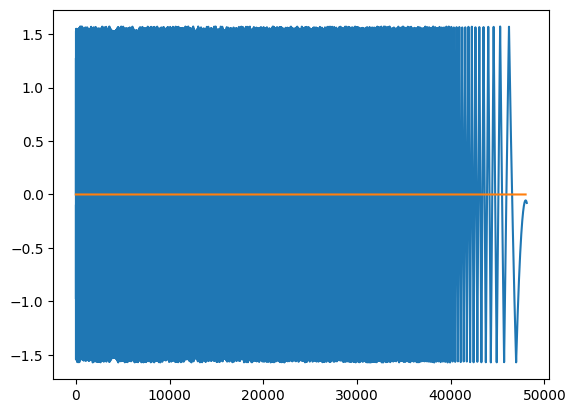

In [29]:
s1 = Synt(C(1), osc.Sine(), amp=Sine(C(2)))


freq = 880
vel = .25

s2 = Synt(Sine(C(vel)) / X1() * C(freq), osc.Triangle())
# e2 = Echo(s2, .3, .25, restar=True)
# showOsc(e2, 10)
showOsc(s2, 1)

plt.plot(np.zeros(SRATE))
input = s2


In [30]:
input = None

In [41]:
octava = 0
harm = HarmSynt(0 + (7 * octava), [osc.Sine()] ,env=EnvADSR(.5, 1, .5, 1, 3), amps=[C(1), C(1), C(1)], amp=C(1), afinacion=notasAJ)
input = harm
# showOsc(harm, .7)

[440, 550, 660]
